O **operador de Koopman** é uma ferramenta poderosa da análise dinâmica não-linear que permite representar a evolução de um sistema não-linear em um espaço de funções observáveis por meio de um operador linear infinito. Na prática, esse operador é aproximado a partir de dados usando métodos como a **Decomposição Dinâmica de Modos (DMD)** ou suas variações, como a **Extended DMD (EDMD)**.

### Passos para Aproximar o Operador de Koopman a partir de Dados:
1. **Coletar Dados**: Obter snapshots do sistema em tempos discretos.
2. **Escolher Observáveis**: Definir um conjunto de funções observáveis (como polinômios, kernels, etc.) para levantar os dados para um espaço de dimensão maior.
3. **Construir Matrizes de Dados**: Organizar os dados em matrizes de estados e estados futuros.
4. **Resolver um Problema de Regressão**: Encontrar a melhor aproximação linear que mapeia os observáveis atuais para os observáveis futuros.

---

### Exemplo Prático: Aproximação do Operador de Koopman via EDMD
Vamos implementar o método **EDMD** para aproximar o operador de Koopman para um sistema não-linear simples: o **oscilador não-linear de Van der Pol**.

#### Passo 1: Simular o Sistema de Van der Pol
O sistema é descrito por:
$$ \dot{x} = y, \quad \dot{y} = \mu (1 - x^2) y - x $$
Vamos usar $\mu = 0.5$ e simular o sistema.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Definir o sistema de Van der Pol
def van_der_pol(t, z, mu):
    x, y = z
    return [y, mu * (1 - x**2) * y - x]

mu = 0.5
t_span = [0, 20]
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1], dt)
z0 = [1.0, 0.0]  # Condição inicial

# Resolver a ODE
sol = solve_ivp(van_der_pol, t_span, z0, args=(mu,), t_eval=t_eval)
X = sol.y  # Dados de estado (2 x N)

#### Passo 2: Construir Matrizes de Dados
Organizamos os dados em pares $(X, Y)$, onde $Y$ é o estado no próximo passo de tempo.

In [2]:
X_data = X[:, :-1]
Y_data = X[:, 1:]

#### Passo 3: Definir Observáveis (Lifting)
Vamos usar observáveis polinomiais (até segunda ordem):
$$ \Phi(x, y) = [1, x, y, x^2, xy, y^2] $$

In [3]:
def lift(X):
    x, y = X
    return np.array([1, x, y, x**2, x*y, y**2])

# Aplicar lifting aos dados
Phi_X = np.apply_along_axis(lift, 0, X_data)
Phi_Y = np.apply_along_axis(lift, 0, Y_data)

#### Passo 4: Aproximar o Operador de Koopman (\(K\))
Resolvemos o problema de mínimos quadrados:
$$ K = \Phi_Y \Phi_X^\dagger $$
onde $\Phi_X^\dagger$ é a pseudo-inversa de $\Phi_X$.

In [4]:
K = Phi_Y @ np.linalg.pinv(Phi_X)
print("Aproximação do operador de Koopman (K):")
print(K)

Aproximação do operador de Koopman (K):
[[ 1.00000000e+00 -1.11076513e-16  1.00234491e-16  1.45859751e-15
   2.37982377e-16  6.21085215e-16]
 [-1.42404703e-05  9.99949890e-01  1.00008620e-02  3.52258475e-06
  -4.48473963e-06  4.72929115e-06]
 [-2.63180731e-03 -1.00216285e-02  1.00016392e+00  6.93846748e-04
  -7.80564407e-04  8.34825677e-04]
 [-9.34161184e-05 -1.52011703e-06 -4.72053394e-06  9.99924286e-01
   1.99392158e-02  1.29527778e-04]
 [-8.07969004e-03 -5.18117899e-05 -3.73615693e-04 -7.91409842e-03
   9.94078863e-01  1.25704704e-02]
 [ 4.59715645e-03 -2.19094864e-04  1.76927044e-04 -5.82208750e-03
  -2.39550480e-02  1.00396711e+00]]


#### Passo 5: Prever a Dinâmica
Podemos usar $K$ para prever a evolução dos observáveis:
$$\Phi_{k+1} \approx K \Phi_k$$

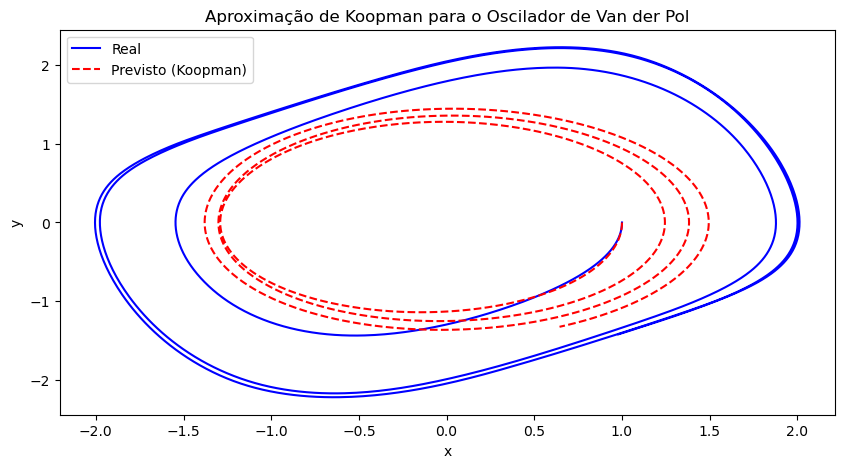

In [5]:
# Prever a dinâmica
Phi_pred = np.zeros_like(Phi_X)
Phi_pred[:, 0] = Phi_X[:, 0]

for t in range(1, Phi_X.shape[1]):
    Phi_pred[:, t] = K @ Phi_pred[:, t-1]

# Extrair x e y previstos (observáveis 2 e 3)
x_pred = Phi_pred[1, :]
y_pred = Phi_pred[2, :]

# Plotar resultados
plt.figure(figsize=(10, 5))
plt.plot(X_data[0], X_data[1], 'b', label='Real')
plt.plot(x_pred, y_pred, 'r--', label='Previsto (Koopman)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("Aproximação de Koopman para o Oscilador de Van der Pol")
plt.show()

### Resultado:
- O operador $K$ aproximado captura a dinâmica não-linear no espaço dos observáveis.
- A previsão (linha tracejada) deve seguir aproximadamente a trajetória real (linha azul), especialmente para curto prazo.

### Observações:
1. A escolha dos observáveis é crítica. Se o sistema tiver dinâmicas mais complexas, podem ser necessários mais observáveis (ex: kernels, redes neurais).
2. Para sistemas caóticos ou de alta dimensão, métodos como **Deep Learning** (ex: Autoencoders + Koopman) são mais eficientes.

Esse exemplo mostra como aproximar o operador de Koopman a partir de dados para um sistema não-linear simples. Para sistemas mais complexos, técnicas avançadas como **DMD Variacional** ou **Koopman com Redes Neurais** podem ser necessárias.